# Examples and Applications

Below are notes from each section of the qiskit course documentation found on this page: https://learn.qiskit.org/course/algorithm-design/applications

## Problem definitions

Imagine we have the following observable that we want to find the eigenvalue of:

$\hat{O_1} = 2II - 2XX + 3YY - 3ZZ$

This observable has the following eigenvalues: {$\lambda_0 = -6, \lambda_1 = 4, \lambda_2 = 4, \lambda_3 = 6$} and eigenstates: {$\ket{\phi_0} = \frac{1}{\sqrt{2}}(\ket{00} + \ket{11}), \ket{\phi_1} = \frac{1}{\sqrt{2}}(\ket{00} - \ket{11}), \ket{\phi_2} = \frac{1}{\sqrt{2}}(\ket{01} - \ket{10}), \ket{\phi_3} = \frac{1}{\sqrt{2}}(\ket{01} + \ket{10})$}.

In [1]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

## Custom VQE

Below is how you could find the solution using a custom VQE.

In [ ]:
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
import numpy as np

# Add your token below
service = QiskitRuntimeService(
    channel="ibm_quantum",
)

def cost_function_vqe(theta):
    observable = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])
    reference_circuit = QuantumCircuit(2)
    reference_circuit.x(0)

    variational_form = TwoLocal(
        2,
        rotation_blocks=["rz", "ry"],
        entanglement_blocks="cx",
        entanglement="linear",
        reps=1,
    )
    ansatz = reference_circuit.compose(variational_form)

    backend = service.backend("ibmq_qasm_simulator")
    
    # Use estimator to get the expected values corresponding to each ansatz
    estimator = Estimator(session=backend)
    job = estimator.run(ansatz, observable, theta)
    values = job.result().values

    return values

In [ ]:
from qiskit.algorithms.optimizers import COBYLA

initial_theta = np.ones(8)
optimizer = COBYLA()

optimizer_result = optimizer.minimize(fun=cost_function_vqe, x0=initial_theta)

optimal_parameters = optimizer_result.x
print(optimal_parameters)

Now we can use those optimal parameters to calculate the minimum eigenvalues.

In [ ]:
observable = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])
reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)
solution = ansatz.bind_parameters(optimal_parameters)

backend = service.backend("ibmq_qasm_simulator")
estimator = Estimator(session=backend)
job = estimator.run(solution, observable)
values = job.result().values

experimental_min_eigenvalue = values[0]
print(experimental_min_eigenvalue)

In [ ]:
from numpy.linalg import eigvalsh

solution_eigenvalue = min(eigvalsh(observable.to_matrix()))
print(
    f"Percent error: {abs((experimental_min_eigenvalue - solution_eigenvalue)/solution_eigenvalue):.2e}"
)

## Configuring Qiskit's VQE

Qiskit's VQE class can also be used instead.

In [ ]:
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SLSQP
from qiskit.algorithms.minimum_eigensolvers import VQE
import numpy as np

estimator = Estimator()
optimizer = SLSQP()
ansatz = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)

vqe = VQE(estimator, ansatz, optimizer, initial_point=np.ones(8))

result = vqe.compute_minimum_eigenvalue(observable)
print(result)

print(result.optimizer_result)

The eignevalue can also be compared with the theoretical.

In [ ]:
from numpy.linalg import eigvalsh

eigenvalues = eigvalsh(observable.to_matrix())
min_eigenvalue = eigenvalues[0]

print("EIGENVALUES:")
print(f"  - Theoretical: {min_eigenvalue}.")
print(f"  - VQE: {result.eigenvalue}")
print(
    f"Percent error >> {abs((result.eigenvalue - min_eigenvalue)/min_eigenvalue):.2e}"
)

### Add reference state

We didn't use a reference operator above. Let's consider the following circuit:

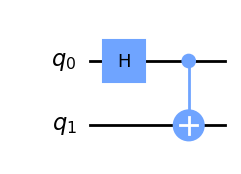

In [3]:
from qiskit import QuantumCircuit

ideal_qc = QuantumCircuit(2)
ideal_qc.h(0)
ideal_qc.cx(0, 1)

ideal_qc.draw("mpl")

In [6]:
from qiskit.quantum_info import Statevector

Statevector(ideal_qc).draw('latex')

<IPython.core.display.Latex object>

This gives us our desired state so we can use a Hadamard gate as our reference circuit to get a better initial reference state.

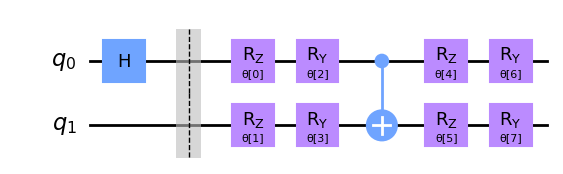

In [9]:
from qiskit.circuit.library import TwoLocal

reference = QuantumCircuit(2)
reference.h(0)
# Include barrier to separate reference from variational form
reference.barrier()

ansatz = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ref_ansatz = ansatz.decompose().compose(reference, front=True)

ref_ansatz.draw("mpl")

### Change initial point

We can also change the initial point to see what happens to our algorithm. When starting with an ideal solution, it should give fewer evaluations, iterations, and time.

## VQD example

The VQD can be used to find all 4 eigenvalues instead of just the lowest. The coefficients of penalty can be passed to the circuit as shown below. For this observable, we expect the following eigenvalues: -7, 3, 5, 7.

In [11]:
from qiskit.primitives import Estimator
from qiskit.primitives import Sampler
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.algorithms.eigensolvers import VQD

optimizer = COBYLA()
sampler = Sampler()
estimator = Estimator()
fidelity = ComputeUncompute(sampler)

k = 4
betas = [40, 60, 30, 30]

vqd = VQD(estimator, fidelity, ansatz, optimizer, k=k, betas=betas)

observable_2 = SparsePauliOp.from_list([("II", 2), ("XX", -3), ("YY", 2), ("ZZ", -4)])

result = vqd.compute_eigenvalues(observable_2)
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': array([ 143,  146, 1000,  131]),
    'eigenvalues': array([-6.99999998+0.j,  3.00000003+0.j,  5.21541851+0.j,  6.789921  +0.j]),
    'optimal_circuits': [   <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7fdfcc1362b0>,
    'optimal_parameters': [   {   ParameterVectorElement(θ[0]): -4.216421215476956,
                                  ParameterVectorElement(θ[5]): 2.4259828797431626,
                                  ParameterVectorElement(θ[7]): -2.765198431207107,
                                  ParameterVectorElement(θ[6]): 0.37632565980553834,
                                  ParameterVectorElement(θ[4]): 5.56756442130925,
                                  ParameterVectorElement(θ[3]): 3.1416172279298085,
                                  ParameterVectorElement(θ[2]): 1.57074963263764,
                                  ParameterVectorElement(θ[1]): -6.2915150385526175},
                              

### Change betas

A requirement of the VQD is that the values of $\Beta$ should be bigger than the difference between the eigenvalues. The qiskit notebook shows what happens when they do not satisfy that condition. Essentially, if the penalization term is not big enough, it won't minimize the eigenstate in the successive cost functions so it returns the same state, $\ket{\phi_0}$ for all k's.

<font color="red">Question: </font>If you are using the QVD to _find_ the eigenvalues, then how would you know what the minimum values for $\beta$ should be? I guess this is something you just have to experiment with.

## Quantum Chemistry: Ground State & Excited Energy Solver

In [ ]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

h2_problem = driver.run()

mapper = JordanWignerMapper()

h2_reference_state = HartreeFock(
    num_spatial_orbitals=h2_problem.num_spatial_orbitals,
    num_particles=h2_problem.num_particles,
    qubit_mapper=mapper,
)

ansatz = UCC(
    num_spatial_orbitals=h2_problem.num_spatial_orbitals,
    num_particles=h2_problem.num_particles,
    qubit_mapper=mapper,
    initial_state=h2_reference_state,
    excitations=2,
)

ansatz.decompose().decompose().draw("mpl")

In [ ]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Sampler, Estimator
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

estimator = Estimator()
sampler = Sampler()
fidelity = ComputeUncompute(sampler)

vqe = VQE(
    estimator=estimator,
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=np.zeros(ansatz.num_parameters),
)
gse = GroundStateEigensolver(qubit_mapper=mapper, solver=vqe)
result = gse.solve(h2_problem)

print(result)

In [ ]:
from qiskit.algorithms.eigensolvers import VQD

h2_operators, _ = gse.get_qubit_operators(h2_problem)

optimizer = COBYLA()
sampler = Sampler()
estimator = Estimator()
fidelity = ComputeUncompute(sampler)

k = 3
betas = [33, 33, 33]

vqd = VQD(
    estimator=estimator,
    ansatz=ansatz,
    optimizer=optimizer,
    fidelity=fidelity,
    initial_point=np.zeros(ansatz.num_parameters),
    k=k,
    betas=betas,
)
result = vqd.compute_eigenvalues(operator=h2_operators)
vqd_values = result.optimal_values
print(vqd_values)

## Optimization: Max-Cut

The Max-Cut is the same as in the Cost Functions page under "Example mapping to non-physical systems".

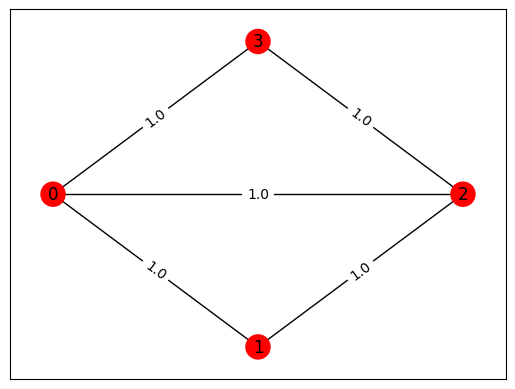

In [12]:
import networkx as nx

n = 4
G = nx.Graph()
G.add_nodes_from(range(n))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_weighted_edges_from(edge_list)

colors = ["red" for i in range(n)]


def draw_graph(G, colors):
    """Draws the graph with the chose colors"""
    layout = nx.shell_layout(G)
    nx.draw_networkx(G, node_color=colors, pos=layout)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)


draw_graph(G, colors)

In [13]:
w = nx.to_numpy_array(G)
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


In [14]:
from qiskit_optimization.applications import Maxcut

max_cut = Maxcut(w)

quadratic_program = max_cut.to_quadratic_program()
print(quadratic_program.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [15]:
observable, offset = quadratic_program.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(observable))

Offset: -2.5
Ising Hamiltonian:
0.5 * IIZZ
+ 0.5 * IZIZ
+ 0.5 * IZZI
+ 0.5 * ZIIZ
+ 0.5 * ZZII


In [16]:
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
import numpy as np

ansatz = TwoLocal(observable.num_qubits, "rx", reps=1)
optimizer = COBYLA()

vqe = VQE(
    estimator=Estimator(),
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=np.zeros(ansatz.num_parameters),
)

result = vqe.compute_minimum_eigenvalue(observable)

print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 132,
    'eigenvalue': -1.4999999927846193,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7fdfada093a0>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): -0.24520204107182722,
                              ParameterVectorElement(θ[2]): -1.2597623076427074,
                              ParameterVectorElement(θ[1]): 1.1324676715479791,
                              ParameterVectorElement(θ[3]): 2.6381628610553904,
                              ParameterVectorElement(θ[7]): 0.5034758180239107,
                              ParameterVectorElement(θ[4]): 0.24517138147075115,
                              ParameterVectorElement(θ[6]): 1.2597830920863473,
                              ParameterVectorElement(θ[5]): 2.00901715618674},
    'optimal_point': array([-0.24520204,  1.13246767, -1.25976231,  2.63816286,  0.24517138,
        2.00901716,  1.25978309,  0.50347582]),
    'op

energy: -1.4999999927846193
time: 0.4976818561553955
max-cut objective: -3.9999999927846193
solution: [0. 1. 0. 1.]
solution objective: 4.0


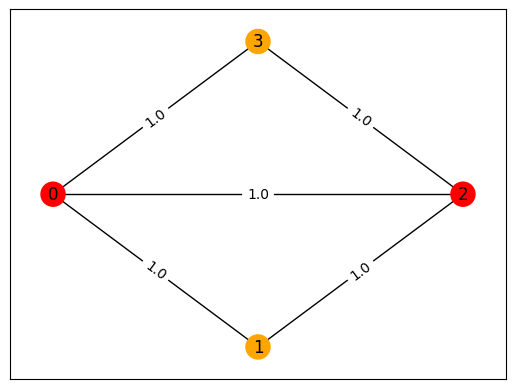

In [17]:
from qiskit.quantum_info import Statevector

optimal_circuit = result.optimal_circuit.bind_parameters(result.optimal_parameters)

x = max_cut.sample_most_likely(Statevector(optimal_circuit))
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", quadratic_program.objective.evaluate(x))

# plot results
colors = ["red" if x[i] == 0 else "orange" for i in range(n)]
draw_graph(G, colors)